In [ ]:
!pip install pycryptodome

Encryption complete. Output file: output_encrypt/random10_encrypt.txt
Encryption complete. Output file: output_encrypt/random9_encrypt.txt
Encryption complete. Output file: output_encrypt/random3_encrypt.txt
Encryption complete. Output file: output_encrypt/random7_encrypt.txt
Encryption complete. Output file: output_encrypt/random5_encrypt.txt
Encryption complete. Output file: output_encrypt/random8_encrypt.txt
Encryption complete. Output file: output_encrypt/random1_encrypt.txt
Encryption complete. Output file: output_encrypt/random2_encrypt.txt
Encryption complete. Output file: output_encrypt/random6_encrypt.txt
Encryption complete. Output file: output_encrypt/random4_encrypt.txt
Decryption complete. Output file: output_decrypt/random10_decrypt.txt
Decryption complete. Output file: output_decrypt/random9_decrypt.txt
Decryption complete. Output file: output_decrypt/random8_decrypt.txt
Decryption complete. Output file: output_decrypt/random4_decrypt.txt
Decryption complete. Output file

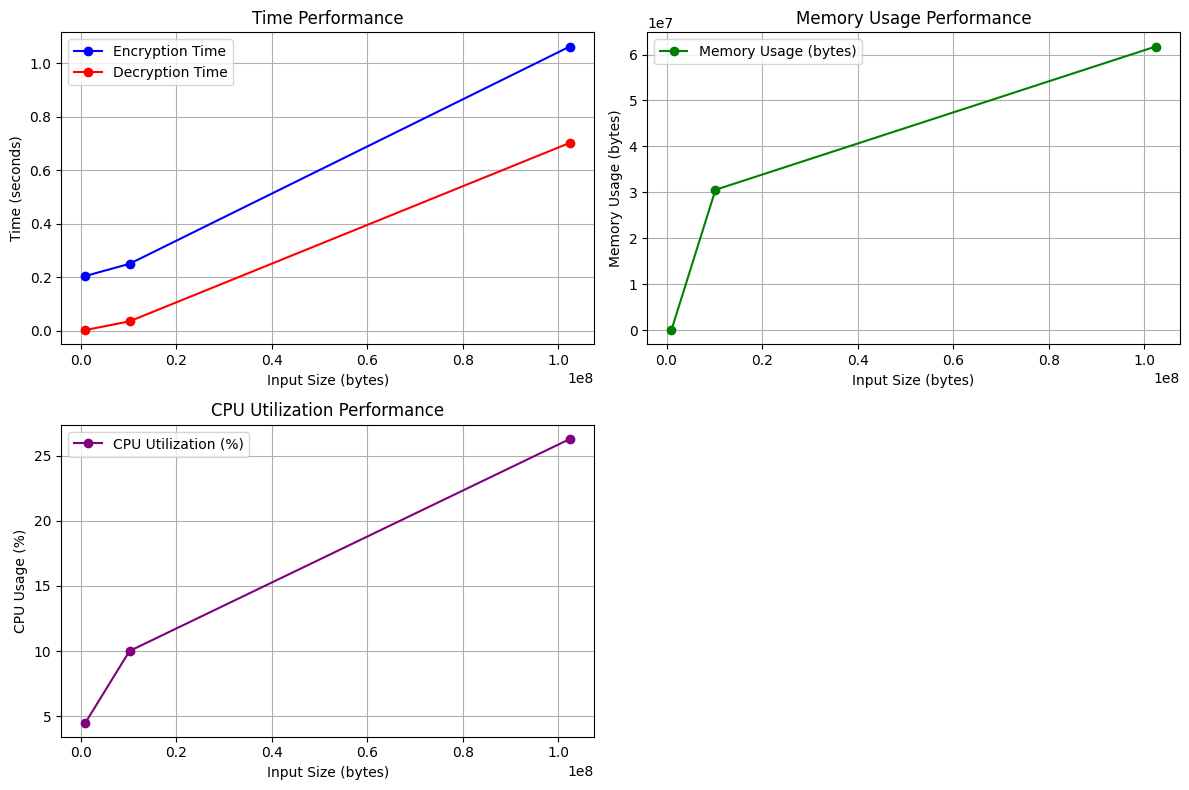

In [ ]:
import os
import time
import psutil
import matplotlib.pyplot as plt
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad

def generate_key():
    """Generates a 256-bit key for AES encryption."""
    return get_random_bytes(32)

def encrypt(data, key):
    """Encrypts data using AES-256.

    Args:
        data (bytes): The plaintext data to encrypt.
        key (bytes): The 256-bit AES key.

    Returns:
        bytes: The encrypted ciphertext.
        bytes: The initialization vector (IV).
    """
    # cipher block chaining mode
    cipher = AES.new(key, AES.MODE_CBC)
    ciphertext = cipher.encrypt(pad(data, AES.block_size))
    return ciphertext, cipher.iv

def decrypt(ciphertext, key, iv):
    """Decrypts data using AES-256.

    Args:
        ciphertext (bytes): The encrypted data to decrypt.
        key (bytes): The 256-bit AES key.
        iv (bytes): The initialization vector (IV).

    Returns:
        bytes: The decrypted plaintext.
    """
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return unpad(cipher.decrypt(ciphertext), AES.block_size)

def handle_file_input_output(file_path, key, mode):
    """Handles file encryption or decryption.

    Args:
        file_path (str): Path to the input file.
        key (bytes): The 256-bit AES key.
        mode (str): 'encrypt' or 'decrypt'.

    Returns:
        None
    """
    try:
        with open(file_path, 'rb') as file:
            data = file.read()

        if mode == 'encrypt':
            ciphertext, iv = encrypt(data, key)
            file_name, file_extension = os.path.splitext(file_path)
            output_file = f"output_encrypt/{file_name.split(os.sep)[-1]}_encrypt{file_extension}"
            with open(output_file, 'wb') as file:
                file.write(iv + ciphertext)

        elif mode == 'decrypt':
            iv = data[:AES.block_size]
            ciphertext = data[AES.block_size:]
            plaintext = decrypt(ciphertext, key, iv)
            file_name, file_extension = os.path.splitext(os.path.basename(file_path))
            output_file = f"output_decrypt/{file_name[:-8]}_decrypt{file_extension}"
            with open(output_file, 'wb') as file:
                file.write(plaintext)

        print(f"{mode.capitalize()}ion complete. Output file: {output_file}")

    except Exception as e:
        print(f"Error during file {mode}: {e}")


def process_files_for_encryption(input_dir, output_encrypt_dir, key):
    os.makedirs(output_encrypt_dir, exist_ok=True)

    # Iterate over all files in the input directory
    for file_name in os.listdir(input_dir):
        input_file_path = os.path.join(input_dir, file_name)
        # process only text files
        if os.path.isfile(input_file_path) and file_name.endswith(".txt"):
            handle_file_input_output(input_file_path, key, "encrypt")


def process_files_for_decryption(output_encrypt_dir, output_decrypt_dir, key):
    os.makedirs(output_decrypt_dir, exist_ok=True)

    # Iterate over all encrypted files in the output_encrypt directory
    for file_name in os.listdir(output_encrypt_dir):
        input_file_path = os.path.join(output_encrypt_dir, file_name)
        # print(input_file_path)
        if os.path.isfile(input_file_path) and file_name.endswith(".txt"):
            handle_file_input_output(input_file_path, key, "decrypt")


# Performance testing
def performance_testing():
    """Tests encryption and decryption performance with resource usage tracking."""
    input_sizes = [1024000, 10240000,102400000]  # 1 MB, 10 MB, 100 MB
    encryption_times, decryption_times = [], []
    memory_usages, cpu_usages = [], []

    key = generate_key()
    process = psutil.Process(os.getpid())

    for size in input_sizes:
        data = os.urandom(size)

        # Encryption performance
        start_time = time.time()
        memory_before = process.memory_info().rss  # Memory before encryption
        cpu_before = psutil.cpu_percent(interval=0.1)  # Wait for 0.1s for more accurate CPU usage
        ciphertext, iv = encrypt(data, key)
        memory_after = process.memory_info().rss  # Memory after encryption
        cpu_after = psutil.cpu_percent(interval=0.1)  # Wait for 0.1s for more accurate CPU usage

        encryption_times.append(time.time() - start_time)
        memory_usages.append(memory_after - memory_before)
        cpu_usages.append(cpu_after - cpu_before)

        # Decryption performance
        start_time = time.time()
        decrypt(ciphertext, key, iv)
        decryption_times.append(time.time() - start_time)

    # Visualization
    plt.figure(figsize=(12, 8))

    # Time metrics
    plt.subplot(2, 2, 1)
    plt.plot(input_sizes, encryption_times, label='Encryption Time', marker='o', linestyle='-', color='blue')
    plt.plot(input_sizes, decryption_times, label='Decryption Time', marker='o', linestyle='-', color='red')
    plt.xlabel('Input Size (bytes)')
    plt.ylabel('Time (seconds)')
    plt.title('Time Performance')
    plt.legend()
    plt.grid()

    # Memory usage
    plt.subplot(2, 2, 2)
    plt.plot(input_sizes, memory_usages, label='Memory Usage (bytes)', marker='o', linestyle='-', color='green')
    plt.xlabel('Input Size (bytes)')
    plt.ylabel('Memory Usage (bytes)')
    plt.title('Memory Usage Performance')
    plt.legend()
    plt.grid()

    # CPU utilization
    plt.subplot(2, 2, 3)
    plt.plot(input_sizes, cpu_usages, label='CPU Utilization (%)', marker='o', linestyle='-', color='purple')
    plt.xlabel('Input Size (bytes)')
    plt.ylabel('CPU Usage (%)')
    plt.title('CPU Utilization Performance')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# MAIN FUNCTION
if __name__ == "__main__":

    key = generate_key()
    input_dir = "/content/input"
    output_encrypt_dir = "output_encrypt"
    output_decrypt_dir = "output_decrypt"
    process_files_for_encryption(input_dir, output_encrypt_dir, key)
    process_files_for_decryption(output_encrypt_dir, output_decrypt_dir, key)

    # Run performance testing
    performance_testing()